# 2 : show glacier evolution dependent on the applied climate change

In [252]:
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
path_merged_runs_scaled = '/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_apr04_models_all_rgi_regions_sum_scaled.nc'

In [253]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from help_func import pal_models, model_order, d_reg_num_name
hue_order = model_order
ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)

In [255]:
import matplotlib
matplotlib.__version__


'3.5.3'

IDEAS:
- for every region, all 80 experiments as lines dependent on the warming scenario (blue to red), either with global warming or regional warming 
- assumptions:
    - do the median over the up to 10 glacier models for every RGI region and all 80 experiments, 
    - add the medians to gether to get the global median volume change estimates
    - repeat the same for the quantiles (0.05,0.25,0.5,0.75,0.95) ...

Do it now with all GCMs at once:

In [256]:
ds_reg_models_vol = ds_reg_models.isel(simulation_year=slice(0,2000)).volume_m3
# Let's take the median/iqr estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])

ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
# this here takes a while
#ds_reg_models_gcm_q25_q50_q75_vol = ds_reg_models_gcm_vol.quantile([0.25,0.5,0.75], dim='model_author')


In [257]:
#ds_reg_models_med_vol.stack

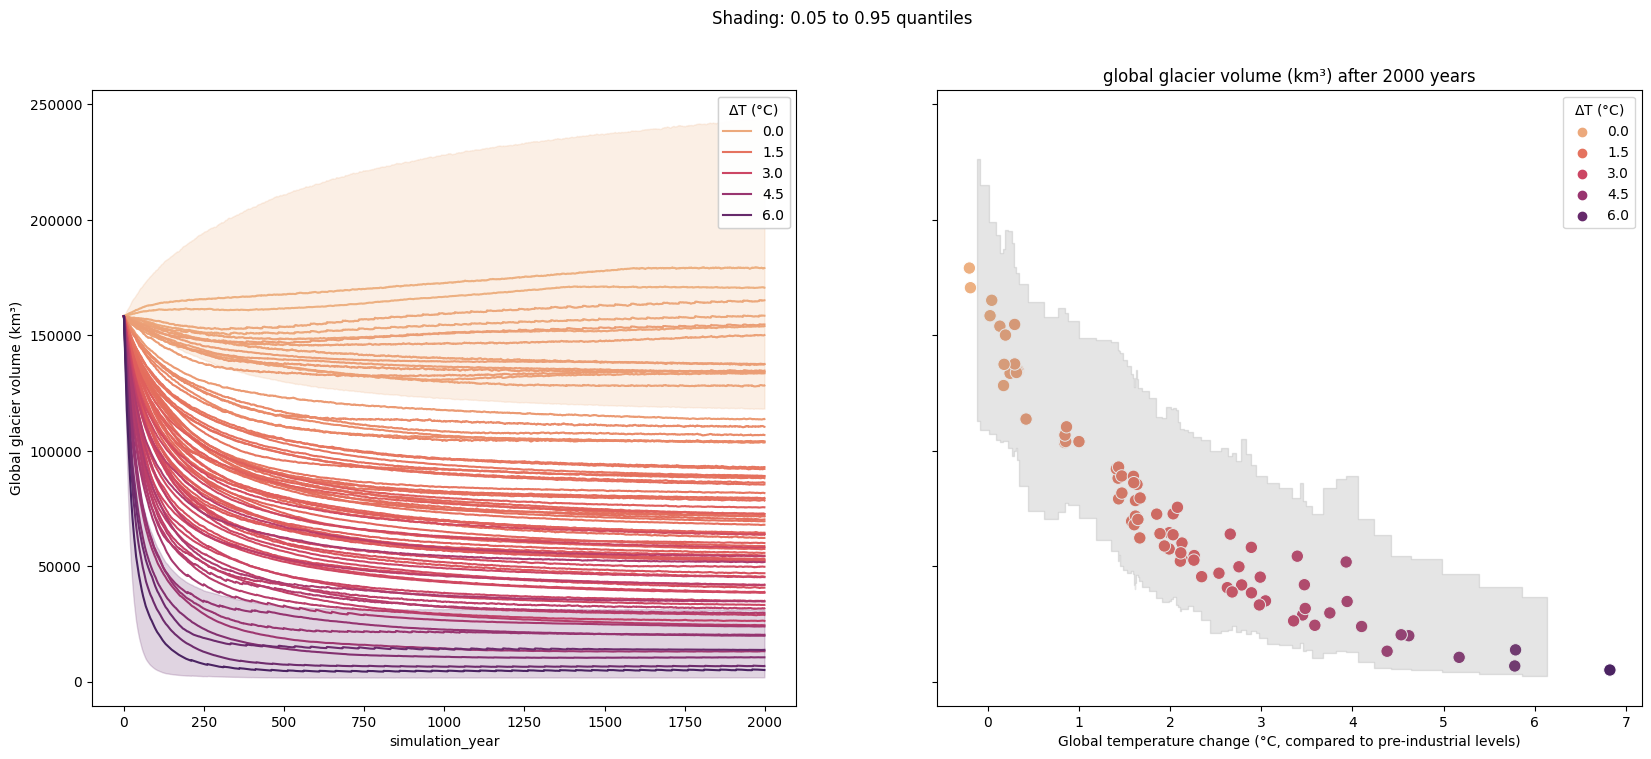

In [262]:
#global
fig,axs= plt.subplots(1,2,figsize=(20,8),sharey=True)
plt.suptitle('Shading: 0.05 to 0.95 quantiles')

ax = axs[0]
ds_reg_models_med_vol_glob = ds_reg_models_med_vol.sum(dim='rgi_reg')
# add global temp. change to the dataset 
pd_global_temp_exp_m = pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                                            pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.reset_coords()

# normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
pd_t =ds_reg_models_med_vol_glob.to_dataframe().reset_index()
#pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
#pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
#pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
#pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
sns.lineplot(ax=ax,
             data=pd_t,
             x='simulation_year',
             y='volume (km3)',
            hue='temp_ch_ipcc', palette='flare',legend='auto',lw=1.5);
leg = ax.get_legend()

exp_temp_min = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmin()
# only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
q05_95_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([0.05,0.95], dim='model_author')/1e9
q05_95_min_glob = q05_95_min.sum(dim='rgi_reg')
ax.fill_between(ds_reg_models_med_vol_glob.simulation_year,
         q05_95_min_glob.sel(quantile=0.05), q05_95_min_glob.sel(quantile=0.95), alpha = 0.2, color=lines.lines[0].get_color(), label='IQR')
handles, labels = ax.get_legend_handles_labels()
t = plt.legend(handles, labels)
ax.add_artist(leg)

exp_temp_max = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmax()
# only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
q05_95_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([0.05,0.95], dim='model_author')/1e9
q05_95_max_glob = q05_95_max.sum(dim='rgi_reg')
ax.fill_between(ds_reg_models_med_vol_glob.simulation_year,
         q05_95_max_glob.sel(quantile=0.05), q05_95_max_glob.sel(quantile=0.95), alpha = 0.2, color=lines.lines[-1].get_color());
ax.set_ylabel('Global glacier volume (km³)')
ax.get_legend().set_title(r'$\Delta$T (°C)')

ax=axs[1]
ax.set_title('global glacier volume (km³) after 2000 years')
sns.scatterplot(ax=ax,
                x='temp_ch_ipcc',
             y='volume (km3)', data = pd_t.loc[pd_t.simulation_year==1999],
            hue='temp_ch_ipcc', palette='flare',legend='auto', s=80)
ax.set_xlabel('Global temperature change (°C, compared to pre-industrial levels)')
ax.get_legend().set_title(r'$\Delta$T (°C)');

q05_95_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([0.05,0.95], dim='model_author')/1e9
q05_95_2000_glob = q05_95_2000.sum(dim='rgi_reg')

q05_95_2000_glob = q05_95_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                               pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
q05_95_2000_glob = q05_95_2000_glob.reset_coords()

q05_95_2000_glob = q05_95_2000_glob.sortby('temp_ch_ipcc')
def smoothen(x, winsize=3):
    return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

plt.fill_between(smoothen(q05_95_2000_glob.temp_ch_ipcc),
                 smoothen(q05_95_2000_glob.volume_m3.sel(quantile=0.05)),
                 smoothen(q05_95_2000_glob.volume_m3.sel(quantile=0.95)),
                 step='mid',
                 interpolate=True,
                 alpha = 0.2, color='grey');
handles, labels = ax.get_legend_handles_labels()

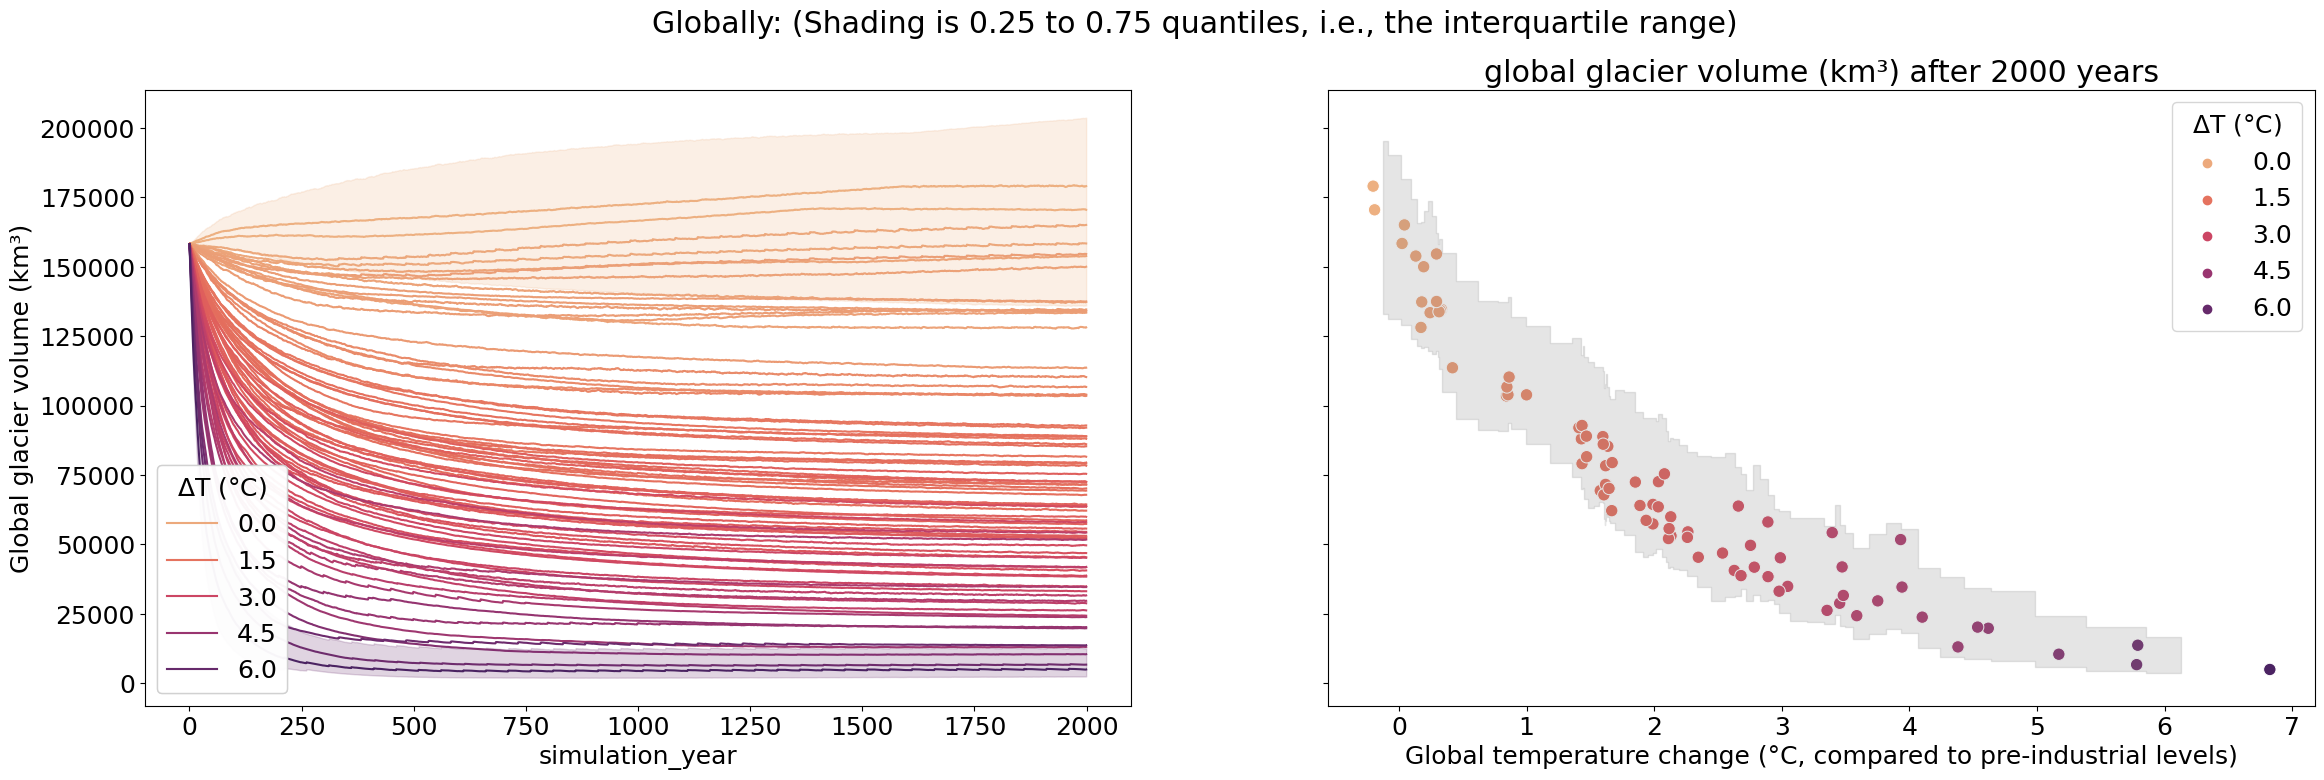

In [281]:
#global
plt.rc('font', size=18)     

fig,axs= plt.subplots(1,2,figsize=(28,8),sharey=True)
plt.suptitle(f'Globally: (Shading is 0.25 to 0.75 quantiles, i.e., the interquartile range)')

ax = axs[0]
ds_reg_models_med_vol_glob = ds_reg_models_med_vol.sum(dim='rgi_reg')
# add global temp. change to the dataset 
pd_global_temp_exp_m = pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                                            pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.reset_coords()

# normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
pd_t =ds_reg_models_med_vol_glob.to_dataframe().reset_index()
#pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
#pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
#pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
#pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
sns.lineplot(ax=ax,
             data=pd_t,
             x='simulation_year',
             y='volume (km3)',
            hue='temp_ch_ipcc', palette='flare',legend='auto',lw=1.5);
leg = ax.get_legend()

exp_temp_min = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmin()
# only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
q25_75_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([0.25,0.75], dim='model_author')/1e9
q25_75_min_glob = q25_75_min.sum(dim='rgi_reg')
ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
         q25_75_min_glob.sel(quantile=0.75), q25_75_min_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color(), label='IQR')
handles, labels = ax.get_legend_handles_labels()
t = plt.legend(handles, labels)
ax.add_artist(leg)

exp_temp_max = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmax()
# only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
q25_75_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([0.25,0.75], dim='model_author')/1e9
q25_75_max_glob = q25_75_max.sum(dim='rgi_reg')
ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
         q25_75_max_glob.sel(quantile=0.75), q25_75_max_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());
ax.set_ylabel('Global glacier volume (km³)')
ax.get_legend().set_title(r'$\Delta$T (°C)')

ax=axs[1]
ax.set_title('global glacier volume (km³) after 2000 years')
sns.scatterplot(ax=ax,
                x='temp_ch_ipcc',
             y='volume (km3)', data = pd_t.loc[pd_t.simulation_year==1999],
            hue='temp_ch_ipcc', palette='flare',legend='auto', s=80)
ax.set_xlabel('Global temperature change (°C, compared to pre-industrial levels)')
ax.get_legend().set_title(r'$\Delta$T (°C)');

q25_75_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([0.25,0.75], dim='model_author')/1e9
q25_75_2000_glob = q25_75_2000.sum(dim='rgi_reg')

q25_75_2000_glob = q25_75_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                               pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
q25_75_2000_glob = q25_75_2000_glob.reset_coords()

q25_75_2000_glob = q25_75_2000_glob.sortby('temp_ch_ipcc')
def smoothen(x, winsize=3):
    return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

plt.fill_between(smoothen(q25_75_2000_glob.temp_ch_ipcc),
                 smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.25)),
                 smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.75)),
                 step='mid',
                 interpolate=True,
                 alpha = 0.2, color='grey');
plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_glob_timeseries_vol_temp_ch.png')


### Same for regional estimates:

In [ ]:
def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    _p = _p.groupby(['gcm','period_scenario']).mean()
    return _p

In [271]:
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)

In [283]:
#global
plt.rc('font', size=18)     
for rgi_reg in rgi_regs:
    fig,axs= plt.subplots(1,2,figsize=(24,8),sharey=True)
    plt.suptitle(f'RGI{rgi_reg} (Shading is 0.25 to 0.75 quantiles, i.e., the interquartile range)')
    ax = axs[0]
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol.sel(rgi_reg=rgi_reg) #ds_reg_models_med_vol.sum(dim='rgi_reg')
    pd_global_temp_exp_m = get_glob_temp_exp(region='global')
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                                          pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    # need that to have bot volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.reset_coords()

    # normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
    pd_t =ds_reg_models_med_vol_glob.to_dataframe().reset_index()
    #pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
    #pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
    pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
    #pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
    #pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
    sns.lineplot(ax=ax,
                 data=pd_t,
                 x='simulation_year',
                 y='volume (km3)',
                hue='temp_ch_ipcc', palette='flare',legend='auto',lw=1.5);
    leg = ax.get_legend()

    exp_temp_min = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmin()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_min_glob = q25_75_min.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             q25_75_min_glob.sel(quantile=0.75), q25_75_min_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color(), label='IQR')
    handles, labels = ax.get_legend_handles_labels()
    t = plt.legend(handles, labels)
    ax.add_artist(leg)

    exp_temp_max = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmax()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_max_glob = q25_75_max.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
                    q25_75_max_glob.sel(quantile=0.75),
                    q25_75_max_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());
    ax.set_ylabel(f'RGI{rgi_reg} glacier volume (km³)')
    ax.get_legend().set_title(r'$\Delta$T (°C)')

    
    ax=axs[1]
    ax.set_title(f'RGI{rgi_reg} glacier volume (km³) after 2000 years')
    sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                 y='volume (km3)', data = pd_t.loc[pd_t.simulation_year==1999],
                hue='temp_ch_ipcc', palette='flare',legend='auto', s=80)

    ax.set_xlabel('Global temperature change (°C, compared to pre-industrial levels)')
    ax.get_legend().set_title(r'$\Delta$T (°C)')


    q25_75_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_2000_glob = q25_75_2000.sel(rgi_reg=rgi_reg) #sum(dim='rgi_reg')

    q25_75_2000_glob = q25_75_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    q25_75_2000_glob = q25_75_2000_glob.reset_coords()

    q25_75_2000_glob = q25_75_2000_glob.sortby('temp_ch_ipcc')
    def smoothen(x, winsize=5):
        return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

    plt.fill_between(smoothen(q25_75_2000_glob.temp_ch_ipcc),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.25)),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.75)),
                     step='mid',
                     interpolate=True,
                     alpha = 0.2, color='grey');
    plt.tight_layout()
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_RGI{rgi_reg}_timeseries_vol_temp_ch.png')
    plt.close()

Now the same but for regional glacier temperature change:

In [282]:
#global
plt.rc('font', size=18)     
for rgi_reg in rgi_regs:
    fig,axs= plt.subplots(1,2,figsize=(24,8),sharey=True)
    plt.suptitle(f'RGI{rgi_reg} (Shading is 0.25 to 0.75 quantiles, i.e., the interquartile range)')
    ax = axs[0]
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol.sel(rgi_reg=rgi_reg) #ds_reg_models_med_vol.sum(dim='rgi_reg')
    # add global temp. change to the dataset 
    pd_global_temp_exp_m = get_glob_temp_exp(region=f'RGI{rgi_reg}_global') # pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                                                pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    # need that to have bot volume_m3 and temp_ch_ipcc as variables
    ds_reg_models_med_vol_glob = ds_reg_models_med_vol_glob.reset_coords()

    # normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
    pd_t =ds_reg_models_med_vol_glob.to_dataframe().reset_index()
    #pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
    #pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
    pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
    #pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
    #pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
    sns.lineplot(ax=ax,
                 data=pd_t,
                 x='simulation_year',
                 y='volume (km3)',
                hue='temp_ch_ipcc', palette='flare',legend='auto',lw=1.5);
    leg = ax.get_legend()

    exp_temp_min = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmin()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_min = ds_reg_models_vol.sel(experiments=exp_temp_min).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_min_glob = q25_75_min.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             q25_75_min_glob.sel(quantile=0.75), q25_75_min_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color(), label='IQR')
    handles, labels = ax.get_legend_handles_labels()
    t = plt.legend(handles, labels)
    ax.add_artist(leg)

    exp_temp_max = ds_reg_models_med_vol_glob.temp_ch_ipcc.idxmax()
    # only compute the quantile for the experiment w. minimum / maximum temperature, then just sum up the quantiles to get from regional to global estimates
    q25_75_max = ds_reg_models_vol.sel(experiments=exp_temp_max).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_max_glob = q25_75_max.sel(rgi_reg=rgi_reg)
    ax.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             q25_75_max_glob.sel(quantile=0.75), q25_75_max_glob.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());
    ax.set_ylabel(f'RGI{rgi_reg} glacier volume (km³)')
    ax.get_legend().set_title(r'$\Delta$T (°C)'+'\nregional glacier')


    ax=axs[1]
    ax.set_title(f'RGI{rgi_reg} glacier volume (km³) after 2000 years')
    sns.scatterplot(ax=ax,
                    x='temp_ch_ipcc',
                 y='volume (km3)', data = pd_t.loc[pd_t.simulation_year==1999],
                hue='temp_ch_ipcc', palette='flare',legend='auto', s=80)
    
    ax.set_xlabel('Regional glacier temperature change (°C, compared to pre-industrial levels)')

    ax.get_legend().set_title(r'$\Delta$T (°C)'+'\nregional glacier');

    q25_75_2000 = ds_reg_models_vol.isel(simulation_year=1999).quantile([0.25,0.75], dim='model_author')/1e9
    q25_75_2000_glob = q25_75_2000.sel(rgi_reg=rgi_reg) #sum(dim='rgi_reg')

    q25_75_2000_glob = q25_75_2000_glob.assign_coords(temp_ch_ipcc = ('experiments',
                                                   pd_global_temp_exp_m.loc[ds_reg_models_med_vol_glob.experiments.values, 'temp_ch_ipcc'].values))
    q25_75_2000_glob = q25_75_2000_glob.reset_coords()

    q25_75_2000_glob = q25_75_2000_glob.sortby('temp_ch_ipcc')
    def smoothen(x, winsize=3):
        return np.array(pd.Series(x).rolling(winsize).mean())[winsize-1:]

    plt.fill_between(smoothen(q25_75_2000_glob.temp_ch_ipcc),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.25)),
                     smoothen(q25_75_2000_glob.volume_m3.sel(quantile=0.75)),
                     step='mid',
                     interpolate=True,
                     alpha = 0.2, color='grey');
    plt.tight_layout()
    plt.savefig(f'figures/2_timeseries_temp_ch_reg_glob/2_RGI{rgi_reg}_timeseries_vol_reg_glac_temp_ch.png')    
    plt.close()

### Random code...

In [ ]:
# OLD: just one GCM

gcm = 'gfdl-esm4'

pd_global_temp_exp_gcm = pd_global_temp_exp.loc[pd_global_temp_exp.gcm ==gcm]
ds_reg_models_gcm_vol = ds_reg_models.sel(gcm = gcm).isel(simulation_year=slice(0,2000)).volume_m3
# Let's take the median/iqr estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_gcm_med_vol = ds_reg_models_gcm_vol.median(dim='model_author')
# this here takes a while
ds_reg_models_gcm_q25_q50_q75_vol = ds_reg_models_gcm_vol.quantile([0.25,0.5,0.75], dim='model_author')
#global
ds_reg_models_gcm_q25_q50_q75_vol_glob = ds_reg_models_gcm_q25_q50_q75_vol.sum(dim='rgi_reg')
# add global temp. change to the dataset 
pd_global_temp_exp_gcm.index = pd_global_temp_exp_gcm.period_scenario
ds_reg_models_gcm_q25_q50_q75_vol_glob = ds_reg_models_gcm_q25_q50_q75_vol_glob.assign_coords(temp_ch_ipcc = ('period_scenario',
                                                                            pd_global_temp_exp_gcm.loc[ds_reg_models_gcm_q25_q50_q75_vol_glob.period_scenario.values, 'temp_ch_ipcc'].values))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_reg_models_gcm_q25_q50_q75_vol_glob = ds_reg_models_gcm_q25_q50_q75_vol_glob.reset_coords()

# normi = matplotlib.colors.Normalize(vmax=4, vmin=-4)
pd_t =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.5).to_dataframe().reset_index()
#pd_q25 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.25).to_dataframe().reset_index()
#pd_q75 =ds_reg_models_gcm_q25_q50_q75_vol_glob.sel(quantile=0.75).to_dataframe().reset_index()
pd_t['volume (km3)'] = pd_t['volume_m3']/1e9
#pd_q25['volume (km3)'] = pd_q25['volume_m3']/1e9
#pd_q75['volume (km3)'] = pd_q75['volume_m3']/1e9
lines = sns.lineplot(data=pd_t,
             x='simulation_year',
             y='volume (km3)',
            hue='temp_ch_ipcc', palette='flare',legend='auto',lw=2);


period_ssp_temp_min = ds_reg_models_gcm_q25_q50_q75_vol_glob.temp_ch_ipcc.idxmin()
sel = ds_reg_models_gcm_q25_q50_q75_vol_glob.volume_m3.sel(period_scenario=period_ssp_temp_min)/1e9
plt.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
         sel.sel(quantile=0.75), sel.sel(quantile=0.25), alpha = 0.2, color=lines.lines[0].get_color())

period_ssp_temp_max = ds_reg_models_gcm_q25_q50_q75_vol_glob.temp_ch_ipcc.idxmax()
sel = ds_reg_models_gcm_q25_q50_q75_vol_glob.volume_m3.sel(period_scenario=period_ssp_temp_max)/1e9
plt.fill_between(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
         sel.sel(quantile=0.75), sel.sel(quantile=0.25), alpha = 0.2, color=lines.lines[-1].get_color());


In [ ]:
for period_scenario in ds_reg_models_gcm_q25_q50_q75_vol_glob.period_scenario:
    ds_reg_models_gcm_q25_q50_q75_vol_glob
    plt.scatter(ds_reg_models_gcm_q25_q50_q75_vol_glob.simulation_year,
             ds_reg_models_gcm_q25_q50_q75_vol_glob.volume_m3.sel(quantile=0.5).sel(period_scenario=period_scenario),
               color=c);

In [ ]:


pd_global_temp_exp_gcm.index = pd_global_temp_exp_gcm.period_scenario

ds_reg_models_med_v_glob = ds_reg_models_med_v.sum(dim='rgi_reg')

# this is really unefficient
ds_reg_models_med_v_glob.to_dataframe().reset_index().pivot_table(values = 'volume_m3', index=)

In [4]:


pd_reg_models_med_v_glob =  ds_reg_models_med_v.sum(dim='rgi_reg').to_dataframe().reset_index().groupby(['period_scenario', 'simulation_year', 'gcm']).sum().reset_index()

pd_v_l = []
for gcm in ds_reg_models.gcm:
    pd_global_temp_exp_gcm = pd_global_temp_exp.loc[pd_global_temp_exp.gcm == 'gcm']
    ds_reg_models_med_v = ds_reg_models.volume_m3.median(dim='model_author').sel(gcm=gcm).sum(dim='rgi_reg')

    ds_reg_models_med_v = ds_reg_models_med_v.assign_coords(temp_ch_ipcc = ('period_ssp',
                                                                            pd_global_temp_exp_gcm.loc[pd_reg_models_med_v_glob.period_scenario, 'temp_ch_ipcc'].values))
    
    pd_v = ds_reg_models_med_v.to_dataframe().reset_index()
    pd_v['gcm'] = gcm.values
    pd_v_l.append(pd_v)
pd_glob_models_med_v = pd.concat(pd_v_l)

ds = pd_glob_models_med_v.groupby(['simulation_year','period_scenario', 'gcm']).mean().to_xarray()

d2000 = pd_glob_models_med_v.loc[pd_glob_models_med_v.simulation_year == 2000]

,gcm,period_scenario,temp_ch_ipcc
0,gfdl-esm4,1851-1870_hist,0.171409
1,gfdl-esm4,1901-1920_hist,0.418289
2,gfdl-esm4,1951-1970_hist,0.332281
3,gfdl-esm4,1995-2014_hist,0.841467
4,gfdl-esm4,2021-2040_ssp126,1.433792
...,...,...,...
75,ukesm1-0-ll,2081-2100_ssp370,5.780495
76,ukesm1-0-ll,2021-2040_ssp585,2.259733
77,ukesm1-0-ll,2041-2060_ssp585,3.586968
78,ukesm1-0-ll,2061-2080_ssp585,5.170544


In [ ]:
plt.plot(ds_reg_models_med_v.simulation_year, ds_reg_models_med_v.volume_m3.sum(dim='rgi_reg'));

In [ ]:

sns.scatterplot(data = pd_glob_models_med_v, x = 'simulation_year', hue='temp_ch_ipcc',
             y='volume_m3', palette='viridis');


sns.lineplot(data = d2000, x = 'temp_ch_ipcc',
             y='volume_m3', palette='viridis');